# Crop Recommendation Model

I will be creating a crop recommendation model which will propose a certain crop which will be the best considering few factors:
- The Ratio of Nitrogen contnent in the soil
- The Ratio of Phosphorus content in the soil
- The ratio of Potassium content in the soil
- Temperature in degrees Celsius
- relative humidity in %
- pH valuye of the soil
- rainfall in mm

**Dataset used: [Crop Recommendation Dataset](https://www.kaggle.com/datasets/varshitanalluri/crop-recommendation-dataset)**

Techonolgies used:
- Tensorflow
- ScikitLearn
- Pandas


---

> *Created by Marcin Wojdalski*



## 0: Setting up Colab, Getting data and importing libraries

In [ ]:
# Checking for the GPU
!nvidia-smi

Mon Jul  8 11:45:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

We will be using Kaggle dataset, so let's download data straight from there


In [ ]:
# Creating popup to get a kaggle.json file (API keys)
from google.colab import files
uploaded_file = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Downloading Kaggle library
!pip install -q kaggle

In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
# Downloading the dataset we will be using
!kaggle datasets download varshitanalluri/crop-recommendation-dataset

Dataset URL: https://www.kaggle.com/datasets/varshitanalluri/crop-recommendation-dataset
License(s): MIT
  0% 0.00/62.4k [00:00<?, ?B/s]
100% 62.4k/62.4k [00:00<00:00, 7.40MB/s]


In [ ]:
# Unzipping file
!unzip crop-recommendation-dataset.zip

Archive:  crop-recommendation-dataset.zip
  inflating: Crop_Recommendation.csv  


Now we will import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPool1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, CategoricalAccuracy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing

### Creating helper functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, model_name, save_to_png=False):
  cm = confusion_matrix(y_true, y_pred, labels=labels)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  cm_display.plot();
  plt.xticks(rotation=90);
  plt.title(f"Confusion Matrix for {model_name}");

  if save_to_png:
    plt.savefig(f"{model_name}_cm")

In [ ]:
def create_modelling_checkpoint(model_name, save_best_only=True):
  return ModelCheckpoint(
      filepath=f"{model_name}.h5",
      monitor="val_loss",
      save_best_only=save_best_only,
      save_weights_only=True
  )

## 1: Exploring and preparing the dataset

In this section, we will be taking a closer look on our Crop Recommendation dataset.

In [ ]:
df = pd.read_csv('/content/Crop_Recommendation.csv')
df.sample(5)

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop
1304,93,22,52,26.587407,81.325632,6.932740,41.875400,Watermelon
71,67,45,38,22.727910,82.170688,7.300411,260.887506,Rice
1955,103,51,20,22.802131,84.146684,7.046607,91.638957,Cotton
656,2,38,18,27.536329,89.929082,6.619891,45.485919,MungBean
1038,99,73,53,26.290390,81.060038,5.871702,118.673037,Banana


In [ ]:
class_names = list(df['Crop'].unique())
class_names.sort()
class_names

['Apple',
 'Banana',
 'Blackgram',
 'ChickPea',
 'Coconut',
 'Coffee',
 'Cotton',
 'Grapes',
 'Jute',
 'KidneyBeans',
 'Lentil',
 'Maize',
 'Mango',
 'MothBeans',
 'MungBean',
 'Muskmelon',
 'Orange',
 'Papaya',
 'PigeonPeas',
 'Pomegranate',
 'Rice',
 'Watermelon']

In [ ]:
# Checking the number of rows
len(df)

2200

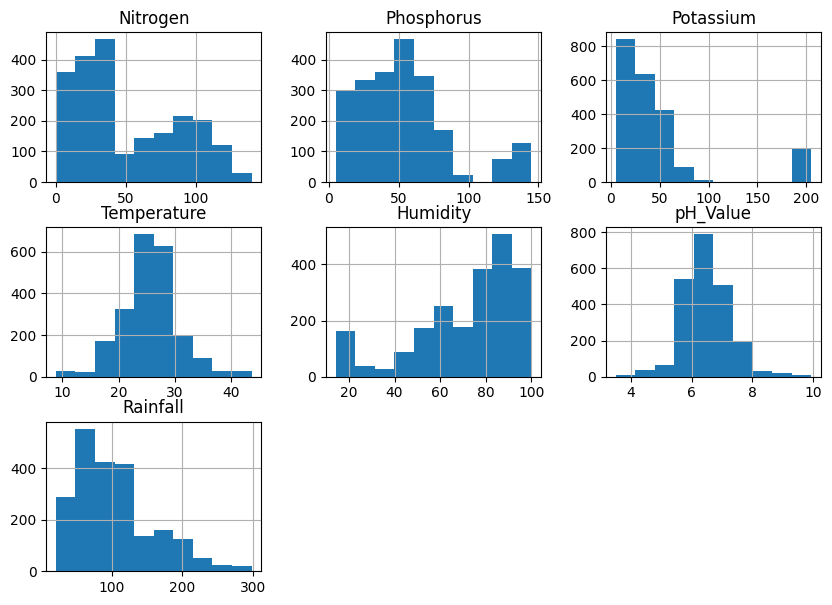

In [ ]:
df.hist(figsize=(10,7));

In [ ]:
df.isna().sum(), df.isnull().sum()

(Nitrogen       0
 Phosphorus     0
 Potassium      0
 Temperature    0
 Humidity       0
 pH_Value       0
 Rainfall       0
 Crop           0
 dtype: int64,
 Nitrogen       0
 Phosphorus     0
 Potassium      0
 Temperature    0
 Humidity       0
 pH_Value       0
 Rainfall       0
 Crop           0
 dtype: int64)

We can see that we don't have any rows which are empty

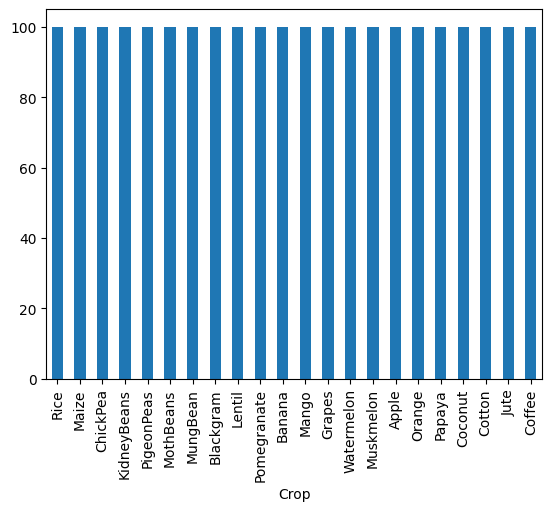

In [ ]:
df['Crop'].value_counts().plot(kind="bar");
plt.show();

We can see that our data is perfectly balanced, so we don't have to do anything about that

In [ ]:
X = df.drop(columns=["Crop"])
y = df["Crop"]

X.head(5)

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
0,90,42,43,20.879744,82.002744,6.502985,202.935536
1,85,58,41,21.770462,80.319644,7.038096,226.655537
2,60,55,44,23.004459,82.320763,7.840207,263.964248
3,74,35,40,26.491096,80.158363,6.980401,242.864034
4,78,42,42,20.130175,81.604873,7.628473,262.717340


In [ ]:
y_one_hot = pd.get_dummies(y).replace({True: 1, False: 0})
y_one_hot.sample(5)

,Apple,Banana,Blackgram,ChickPea,Coconut,Coffee,Cotton,Grapes,Jute,KidneyBeans,...,Mango,MothBeans,MungBean,Muskmelon,Orange,Papaya,PigeonPeas,Pomegranate,Rice,Watermelon
1784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1204,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1931,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
782,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
268,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Normalizing the data
X = preprocessing.normalize(X)
X[:5]

array([[0.36712213, 0.17132366, 0.1754028 , 0.08517129, 0.33450025,
        0.02652655, 0.82780141],
       [0.31986216, 0.21825888, 0.15428645, 0.08192408, 0.30224958,
        0.02648495, 0.85292387],
       [0.20506918, 0.18798008, 0.15038407, 0.07862509, 0.28135753,
        0.02679641, 0.90218221],
       [0.27118819, 0.12826468, 0.14658821, 0.09708206, 0.29375677,
        0.02558111, 0.8900251 ],
       [0.2663572 , 0.14342311, 0.14342311, 0.06874124, 0.27866725,
        0.02604998, 0.8971366 ]])

In [ ]:
# Creating train and test datasets (not One-hot encoded)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
y_train_one_hot = pd.get_dummies(y_train).replace({True: 1, False: 0})
y_test_one_hot = pd.get_dummies(y_test).replace({True: 1, False: 0})

y_train_one_hot.sample(2), y_test_one_hot.sample(2)

(      Apple  Banana  Blackgram  ChickPea  Coconut  Coffee  Cotton  Grapes  \
 660       0       0          0         0        0       0       0       0   
 1731      0       0          0         0        0       0       0       0   
 
       Jute  KidneyBeans  ...  Mango  MothBeans  MungBean  Muskmelon  Orange  \
 660      0            0  ...      0          0         1          0       0   
 1731     0            0  ...      0          0         0          0       0   
 
       Papaya  PigeonPeas  Pomegranate  Rice  Watermelon  
 660        0           0            0     0           0  
 1731       1           0            0     0           0  
 
 [2 rows x 22 columns],
       Apple  Banana  Blackgram  ChickPea  Coconut  Coffee  Cotton  Grapes  \
 1555      1       0          0         0        0       0       0       0   
 534       0       0          0         0        0       0       0       0   
 
       Jute  KidneyBeans  ...  Mango  MothBeans  MungBean  Muskmelon  Orange  \
 15

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1540, 7), (660, 7), (1540,), (660,))

## 2.Creating a Machine Learning Model (Baseline)

We will be using SVC from sklearn to create a baseline model.

In [ ]:
baseline_model = SVC(kernel="rbf", C=10)
baseline_model.fit(X_train, y_train)

SVC(C=10)

In [ ]:
# Checking the classification report
baseline_pred = baseline_model.predict(X_test)

baseline_clf_report = classification_report(y_test, baseline_pred, output_dict=True, target_names=class_names)
baseline_clf_report_df = pd.DataFrame(baseline_clf_report).transpose()
baseline_clf_report_df

,precision,recall,f1-score,support
Apple,1.000000,1.000000,1.000000,34.000000
Banana,1.000000,1.000000,1.000000,26.000000
Blackgram,0.857143,0.923077,0.888889,26.000000
ChickPea,1.000000,1.000000,1.000000,34.000000
Coconut,1.000000,1.000000,1.000000,33.000000
Coffee,0.967742,1.000000,0.983607,30.000000
Cotton,0.875000,1.000000,0.933333,28.000000
Grapes,1.000000,1.000000,1.000000,23.000000
Jute,0.761905,0.941176,0.842105,34.000000
KidneyBeans,1.000000,1.000000,1.000000,36.000000


In [ ]:
baseline_accuracy = baseline_clf_report["accuracy"]
baseline_accuracy

0.9606060606060606

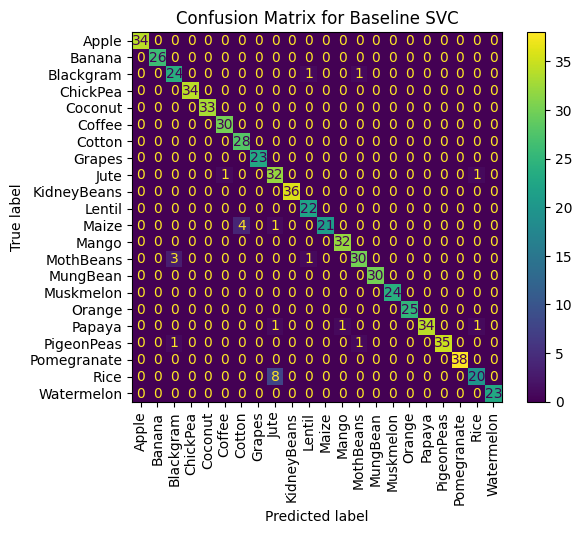

In [ ]:
# Plotting confusion matrix
plot_confusion_matrix(y_test, baseline_pred, class_names, "Baseline SVC", save_to_png=True)

We've achieved a 96% accuracy, which now we will try to beat using Deep Learning approach.

## 3.Model 1: Simple Dense model

In [ ]:
model_1 = Sequential([
    Dense(250, activation="relu"),
    Dense(100, activation="relu"),
    Dense(22, activation="softmax")
], name="model_1_simple_dense")

model_1.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=[CategoricalAccuracy()]
)

model_1_history = model_1.fit(
    X_train,
    y_train_one_hot,
    epochs=150,
    validation_data=(X_test, y_test_one_hot),
    batch_size=64,
    callbacks=[create_modelling_checkpoint(model_name=model_1.name,
                                           save_best_only=True,)]
)

Epoch 1/150
25/25 [==============================] - 5s 35ms/step - loss: 3.0158 - categorical_accuracy: 0.1714 - val_loss: 2.9314 - val_categorical_accuracy: 0.2485
Epoch 2/150
25/25 [==============================] - 0s 16ms/step - loss: 2.7851 - categorical_accuracy: 0.3000 - val_loss: 2.6287 - val_categorical_accuracy: 0.3424
Epoch 3/150
25/25 [==============================] - 0s 15ms/step - loss: 2.3865 - categorical_accuracy: 0.4266 - val_loss: 2.1770 - val_categorical_accuracy: 0.4894
Epoch 4/150
25/25 [==============================] - 0s 5ms/step - loss: 1.9039 - categorical_accuracy: 0.5617 - val_loss: 1.7239 - val_categorical_accuracy: 0.6061
Epoch 5/150
25/25 [==============================] - 0s 7ms/step - loss: 1.5013 - categorical_accuracy: 0.6727 - val_loss: 1.3812 - val_categorical_accuracy: 0.7030
Epoch 6/150
25/25 [==============================] - 0s 8ms/step - loss: 1.2137 - categorical_accuracy: 0.7299 - val_loss: 1.1427 - val_categorical_accuracy: 0.7894
Epoch 7

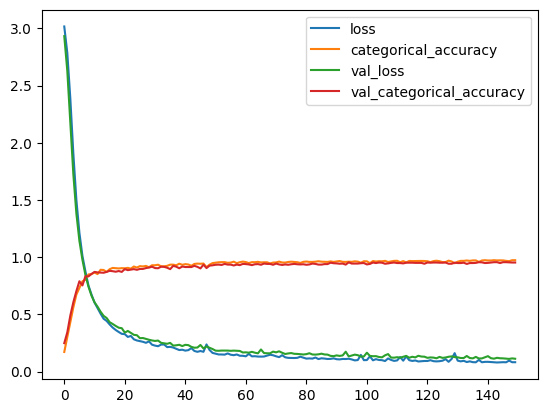

In [ ]:
model_1_history = pd.DataFrame(model_1_history.history)
model_1_history.plot();

In [ ]:
model_1.load_weights("model_1_simple_dense.h5")
model_1.evaluate(X_test, y_test_one_hot)

21/21 [==============================] - 0s 3ms/step - loss: 0.1108 - categorical_accuracy: 0.9545


[0.11082842200994492, 0.9545454382896423]

**We can see that model_1's accuracy is nearly the same as the baseline's.**

In [ ]:
model_1_pred_probs = model_1.predict(X_test)

model_1_pred = np.argmax(model_1_pred_probs, axis=1)
model_1_pred[:3]

model_1_pred_classes = [class_names[i] for i in model_1_pred]
model_1_pred_classes[:3]

21/21 [==============================] - 0s 2ms/step


['Muskmelon', 'Watermelon', 'Papaya']

In [ ]:
model_1_clf_report = classification_report(y_test, model_1_pred_classes, output_dict=True)
model_1_clf_report_df = pd.DataFrame(model_1_clf_report).transpose()
model_1_clf_report_df

,precision,recall,f1-score,support
Apple,1.000000,1.000000,1.000000,34.000000
Banana,1.000000,1.000000,1.000000,26.000000
Blackgram,0.884615,0.884615,0.884615,26.000000
ChickPea,1.000000,1.000000,1.000000,34.000000
Coconut,1.000000,1.000000,1.000000,33.000000
Coffee,0.967742,1.000000,0.983607,30.000000
Cotton,0.892857,0.892857,0.892857,28.000000
Grapes,1.000000,1.000000,1.000000,23.000000
Jute,0.775000,0.911765,0.837838,34.000000
KidneyBeans,0.972222,0.972222,0.972222,36.000000


In [ ]:
model_1_accuracy = model_1_clf_report["accuracy"]
model_1_accuracy

0.9545454545454546

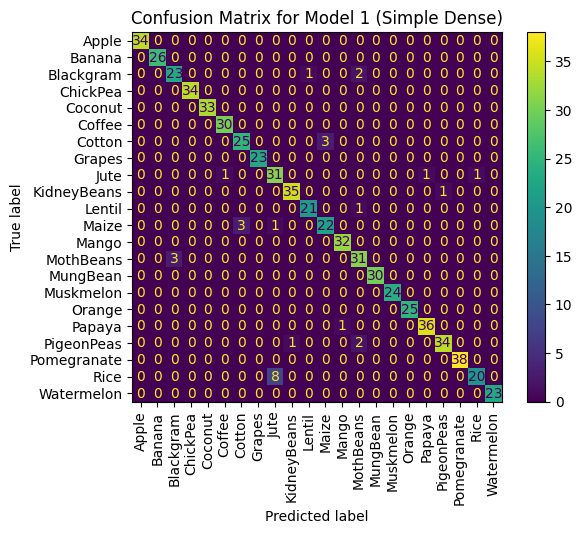

In [ ]:
# Plotting confusion matrix
plot_confusion_matrix(y_test, model_1_pred_classes, class_names, "Model 1 (Simple Dense)", save_to_png=True)

## 4.Model 2: More complex Dense model

Here we will be creating a more complex Dense model with more layers, including dropouts.

It will be trained for more epochs, because it consists of few dropout layers, so we have to give it more time.

In [ ]:
model_2 = Sequential([
    Dense(1024, activation="leaky_relu"),
    Dropout(0.5),
    Dense(512, activation="relu"),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(22, activation="softmax")
], name="model_2_more_complex")

model_2.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=[CategoricalAccuracy()]
)

model_2_history = model_2.fit(
    X_train,
    y_train_one_hot,
    epochs=2000,
    batch_size=64,
    validation_data=(X_test, y_test_one_hot),
    callbacks=[create_modelling_checkpoint(model_name=model_2.name,
                                           save_best_only=True),
               ReduceLROnPlateau(patience=100), EarlyStopping(patience=200)]
)

Epoch 1/2000
25/25 [==============================] - 3s 22ms/step - loss: 2.8852 - categorical_accuracy: 0.1545 - val_loss: 2.3309 - val_categorical_accuracy: 0.2424 - lr: 0.0010
Epoch 2/2000
25/25 [==============================] - 0s 12ms/step - loss: 1.8642 - categorical_accuracy: 0.3818 - val_loss: 1.2617 - val_categorical_accuracy: 0.6106 - lr: 0.0010
Epoch 3/2000
25/25 [==============================] - 0s 13ms/step - loss: 1.2319 - categorical_accuracy: 0.5500 - val_loss: 0.8660 - val_categorical_accuracy: 0.7182 - lr: 0.0010
Epoch 4/2000
25/25 [==============================] - 0s 10ms/step - loss: 0.9182 - categorical_accuracy: 0.6429 - val_loss: 0.6734 - val_categorical_accuracy: 0.7788 - lr: 0.0010
Epoch 5/2000
25/25 [==============================] - 0s 9ms/step - loss: 0.7665 - categorical_accuracy: 0.7156 - val_loss: 0.5282 - val_categorical_accuracy: 0.7909 - lr: 0.0010
Epoch 6/2000
25/25 [==============================] - 0s 10ms/step - loss: 0.6833 - categorical_accur

In [ ]:
model_2.summary()

Model: "model_2_more_complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1024)              8192      
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 22)       

In [ ]:
model_2.load_weights("/content/model_2_more_complex.h5")
model_2.evaluate(X_test, y_test_one_hot)

21/21 [==============================] - 0s 3ms/step - loss: 0.0782 - categorical_accuracy: 0.9712


[0.07822470366954803, 0.9712121486663818]

**We can see that we've beaten our baseline model (96% accuracy) by achieving 97,3% accuracy.** Let's see how does the confusion matrix and classification report look like.

In [ ]:
model_2_pred_probs = model_2.predict(X_test)

model_2_pred = np.argmax(model_2_pred_probs, axis=1)
model_2_pred[:3]

model_2_pred_classes = [class_names[i] for i in model_2_pred]
model_2_pred_classes[:3]

21/21 [==============================] - 0s 2ms/step


['Muskmelon', 'Watermelon', 'Papaya']

In [ ]:
model_2_clf_report = classification_report(y_test, model_2_pred_classes, output_dict=True)
model_2_clf_report_df = pd.DataFrame(model_2_clf_report).transpose()
model_2_clf_report_df

,precision,recall,f1-score,support
Apple,1.000000,1.000000,1.000000,34.000000
Banana,1.000000,1.000000,1.000000,26.000000
Blackgram,0.862069,0.961538,0.909091,26.000000
ChickPea,1.000000,1.000000,1.000000,34.000000
Coconut,1.000000,1.000000,1.000000,33.000000
Coffee,0.967742,1.000000,0.983607,30.000000
Cotton,0.875000,1.000000,0.933333,28.000000
Grapes,1.000000,1.000000,1.000000,23.000000
Jute,0.888889,0.941176,0.914286,34.000000
KidneyBeans,0.972973,1.000000,0.986301,36.000000


In [ ]:
model_2_accuracy = model_2_clf_report["accuracy"]
model_2_accuracy

0.9712121212121212

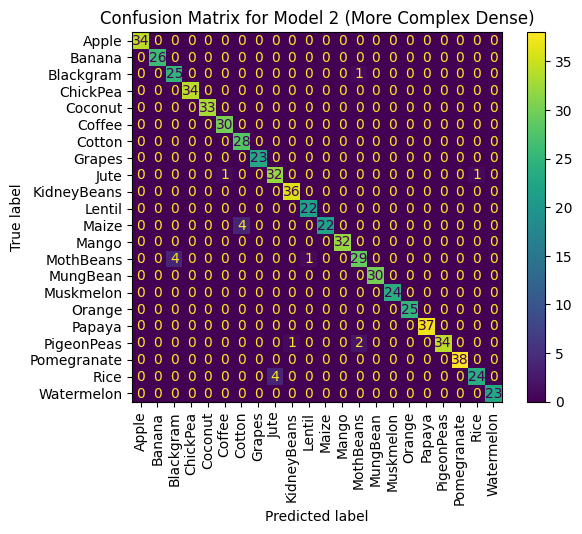

In [ ]:
plot_confusion_matrix(y_test, model_2_pred_classes, class_names, "Model 2 (More Complex Dense)", save_to_png=True)

## 5.Model 3: Experimenting with Conv1D

Here, we will be trying to experiment with creating a CNN, using Conv1D to see if we can beat the baseline and model 2.

In [ ]:
X_train.shape

(1540, 7)

In [ ]:
model_3 = Sequential([
    Conv1D(64, 2, activation="leaky_relu", input_shape=(7,1)),
    Conv1D(32, 4, activation="relu"),
    Conv1D(16, 2, activation="relu"),
    MaxPool1D(1),
    Flatten(),
    Dense(22, activation="softmax")
], name="model_3_cnn")

model_3.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=[CategoricalAccuracy()]
)

model_3_history = model_3.fit(
    X_train,
    y_train_one_hot,
    epochs=2000,
    batch_size=64,
    validation_data=(X_test, y_test_one_hot),
    callbacks=[create_modelling_checkpoint(model_name=model_3.name,
                                           save_best_only=True),
               ReduceLROnPlateau(patience=100), EarlyStopping(patience=200)]
)

Epoch 1/2000
25/25 [==============================] - 2s 14ms/step - loss: 3.0657 - categorical_accuracy: 0.1130 - val_loss: 3.0386 - val_categorical_accuracy: 0.1318 - lr: 0.0010
Epoch 2/2000
25/25 [==============================] - 0s 10ms/step - loss: 2.9788 - categorical_accuracy: 0.2071 - val_loss: 2.9135 - val_categorical_accuracy: 0.2212 - lr: 0.0010
Epoch 3/2000
25/25 [==============================] - 0s 8ms/step - loss: 2.7743 - categorical_accuracy: 0.2045 - val_loss: 2.6519 - val_categorical_accuracy: 0.1894 - lr: 0.0010
Epoch 4/2000
25/25 [==============================] - 0s 10ms/step - loss: 2.4217 - categorical_accuracy: 0.2675 - val_loss: 2.2680 - val_categorical_accuracy: 0.3197 - lr: 0.0010
Epoch 5/2000
25/25 [==============================] - 0s 11ms/step - loss: 2.0052 - categorical_accuracy: 0.4039 - val_loss: 1.8236 - val_categorical_accuracy: 0.4879 - lr: 0.0010
Epoch 6/2000
25/25 [==============================] - 0s 9ms/step - loss: 1.5834 - categorical_accura

In [ ]:
model_3.load_weights("/content/model_3_cnn.h5")
model_3.evaluate(X_test, y_test_one_hot)

21/21 [==============================] - 0s 3ms/step - loss: 0.0990 - categorical_accuracy: 0.9621


[0.0990481749176979, 0.9621211886405945]

In [ ]:
model_3_pred_probs = model_3.predict(X_test)

model_3_pred = np.argmax(model_3_pred_probs, axis=1)

model_3_pred_classes = [class_names[i] for i in model_3_pred]
model_3_pred_classes[:5]

21/21 [==============================] - 0s 2ms/step


['Muskmelon', 'Watermelon', 'Papaya', 'Papaya', 'Apple']

In [ ]:
model_3_clf_report = classification_report(y_test, model_3_pred_classes, output_dict=True)
model_3_clf_report_df = pd.DataFrame(model_3_clf_report).transpose()
model_3_clf_report_df

,precision,recall,f1-score,support
Apple,1.000000,1.000000,1.000000,34.000000
Banana,1.000000,1.000000,1.000000,26.000000
Blackgram,0.827586,0.923077,0.872727,26.000000
ChickPea,1.000000,1.000000,1.000000,34.000000
Coconut,1.000000,1.000000,1.000000,33.000000
Coffee,0.967742,1.000000,0.983607,30.000000
Cotton,0.870968,0.964286,0.915254,28.000000
Grapes,1.000000,1.000000,1.000000,23.000000
Jute,0.864865,0.941176,0.901408,34.000000
KidneyBeans,1.000000,0.972222,0.985915,36.000000


In [111]:
model_3_accuracy = model_3_clf_report["accuracy"]
model_3_accuracy

0.9621212121212122

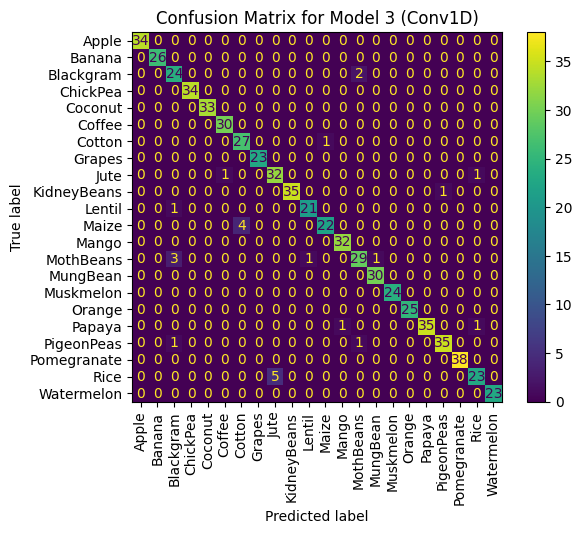

In [ ]:
plot_confusion_matrix(y_test, model_3_pred_classes, class_names, "Model 3 (Conv1D)", save_to_png=True)

## Comparing performance of different models

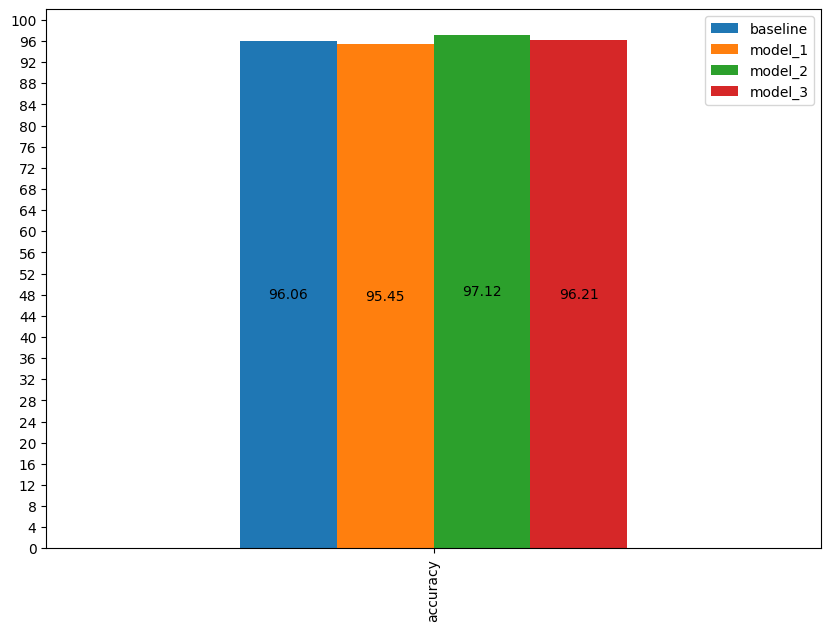

In [ ]:
evaluation_df = pd.DataFrame({
    "baseline": baseline_accuracy,
    "model_1": model_1_accuracy,
    "model_2": model_2_accuracy,
    "model_3": model_3_accuracy
}, index=["accuracy"]).multiply(100).round(2)

ax = evaluation_df.plot(kind="bar", figsize=(10, 7));

for container in ax.containers:
    ax.bar_label(container, label_type="center")

y_values = range(0, 101, 4)

plt.yticks(y_values);

We can see that the best model in this series of experiments is our `model 2` which achieved accuracy of **97.12%**.

There is definitely a little bit of space to improve this metric (e.g. by tuning the hyperparameters), however accuracy achieved here looks very good, so I won't be tuning it.
